### TP 1 : General Observation on Order Book Data

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [1]:
# Step 0 : Download of libraries
## allowed libs :  numpy, scipy, pandas, matplotlib, powerlaw, statsmodels,
## tqdm, Hawkes.

import numpy 
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
import tqdm   
import Hawkes as hwk

Question 1 : General sanity check and statistical analysis on the dataset

In [2]:
# Step 1: Load all files in the directory
data_path = "Data/SG/"
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]
# Create a list to store each DataFrame
df_list = []
for file in file_list:
    df = pd.read_csv(data_path + file, compression='gzip')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list.append(df)

# Concatenate all DataFrames into one
filename_df = pd.concat(df_list, ignore_index=True)

In [3]:
# Step 2 : General statistical analysis on the dataset
# 2.1. Check the structure of the data
filename_df.loc[(filename_df['eqty']<0)].head(10)

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
173,2017-01-17 09:01:09.766010,M,46195,-200,S,46040,660,46100,19
245,2017-01-17 09:01:13.855505,M,46190,-200,S,46050,735,46100,19
335,2017-01-17 09:01:16.658868,M,46050,-200,B,46100,530,46165,397
358,2017-01-17 09:01:18.518978,M,46030,-200,B,46100,891,46165,397
383,2017-01-17 09:01:22.111607,M,46240,-200,S,46100,1302,46165,397
500,2017-01-17 09:01:58.237495,M,46185,-200,S,46040,475,46160,230
699,2017-01-17 09:02:06.815535,M,46195,-200,S,46080,492,46110,197
725,2017-01-17 09:02:08.245301,M,46190,-200,S,46080,803,46115,893
818,2017-01-17 09:02:14.394478,M,46410,-14809,S,46060,400,46115,893
957,2017-01-17 09:02:51.389667,M,46195,-200,S,46070,111,46080,302


In [4]:
# 2.2. Check for missing values
print("DataFrame Info:")
print(filename_df.info())

print("\nMissing values per column:")
print(filename_df.isnull().sum())

# 2.3. Descriptive statistics
print("\nDescriptive Statistics:")
print(filename_df.describe())
print(filename_df['etype'].value_counts())
# 2.4. Check for duplicates (optional)
duplicates = filename_df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicates}")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7827010 entries, 0 to 7827009
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ets     datetime64[ns]
 1   etype   object        
 2   eprice  int64         
 3   eqty    int64         
 4   eside   object        
 5   bp0     int64         
 6   bq0     int64         
 7   ap0     int64         
 8   aq0     int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 537.4+ MB
None

Missing values per column:
ets       0
etype     0
eprice    0
eqty      0
eside     0
bp0       0
bq0       0
ap0       0
aq0       0
dtype: int64

Descriptive Statistics:
                                 ets        eprice          eqty  \
count                        7827010  7.827010e+06  7.827010e+06   
mean   2017-01-24 22:36:25.109865984  4.630138e+04  2.330215e+02   
min       2017-01-17 09:01:00.270164  4.600000e+03 -2.217800e+04   
25%    2017-01-19 16:16:42.942011136  4.56

Comments : The dataset shows a full day’s worth of trading events with no 
missing or duplicate rows, which is excellent for high-frequency analysis. 
Prices range from about 40 000 to 60 760, and best bid/ask prices behave as 
expected.  
One notable element is negative eqty, which indicate a modification that 
removes liquidity (it buyer or seller liquidity). Otherwise, the data appears 
reasonably clean and well-structured for deeper market microstructure studies.

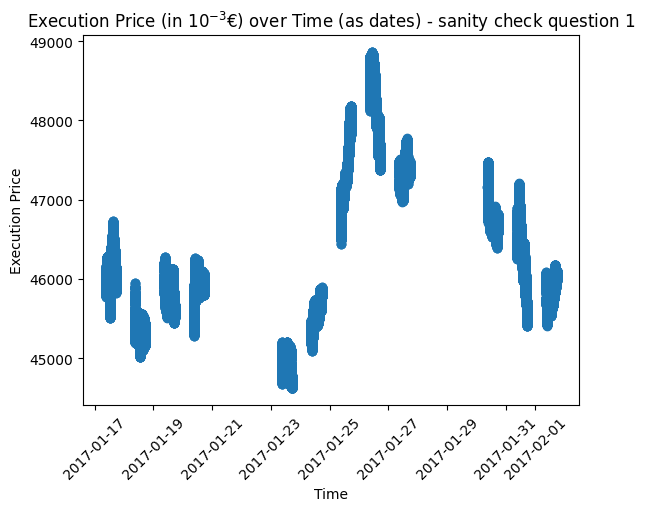

In [5]:
# We are first going to plot the exec price over time
actual_exec_df = filename_df[filename_df['etype'] == 'T']
plt.scatter(actual_exec_df['ets'], actual_exec_df['eprice'], marker='o')
plt.title("Execution Price (in $10^{-3}$€) over Time (as dates) - sanity check question 1")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Execution Price")
plt.show()

Comments : without filtering on actual trades, some exec prices 
are outliers, because they correspond to orders far from the actual last 
price. We confirmed this hypothesis by keeping only the orders that have  
been actually executed, filtering on the "etype" and taking it equal to "T",
the "outliers" go away and it confirms that the data is clean.
Note that we have 4 types of LOB events: A for added trades, M for modified, 
C for cancelled and T for trades.

Question 2 : We will plot bid ask mid and compute the observed tick size

In [6]:
## adding for Question 2 and 4
filename_df['mid_price'] = (filename_df['bp0'] + filename_df['ap0']) / 2
filename_df['weighted_mid_price'] = (
    filename_df['bp0'] * filename_df['bq0'] + filename_df['ap0'] * filename_df['aq0']
) / (filename_df['bq0'] + filename_df['aq0'])
filename_df['spread'] = filename_df['ap0'] - filename_df['bp0']

Comments : We defined the mid price between the ask and the bid prices, as 
well as the weighted mid price calculated with the quantities for best bid and 
ask. The last value we defined here is the spread, which is the difference 
between the best ask price and the best bid price. 

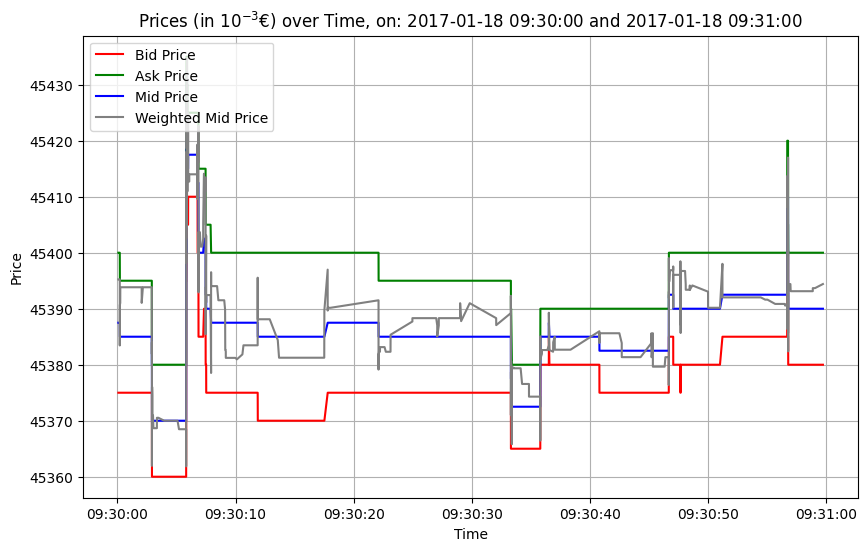

In [7]:
# question 2 : Plot the best bid and ask prices over time, and mid price

#### params ####
start_time = pd.Timestamp("2017-01-18 09:30:00")
end_time = pd.Timestamp("2017-01-18 09:31:00")
################

subset_df = filename_df[(filename_df['ets'] >= start_time) &  
                        (filename_df['ets'] <= end_time)]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(subset_df['ets'], subset_df['bp0'], color = "r", label="Bid Price")
ax1.plot(subset_df['ets'], subset_df['ap0'], color = "g", label="Ask Price")
ax1.plot(subset_df['ets'], subset_df['mid_price'],  color = "b", label="Mid "
                                                                       "Price")
ax1.plot(subset_df['ets'], subset_df['weighted_mid_price'], color = "gray", 
         label="Weighted Mid Price")

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")

ax1.legend(loc='upper left')
plt.title("Prices (in $10^{-3}$€) over Time, on: " + str(start_time) + " and " +
          str(end_time))
plt.grid(True)
plt.show()

Comments : The plot shows the best bid and ask prices over time (for a 
duration of one minute), along with the mid price and the weighted mid price.
The mid price is the average of the best bid and ask prices, while the 
weighted mid price is the average of the best bid and ask prices weighted by
their respective quantities. The plot shows that the mid price and the 
weighted mid price are very close, as expected, and that the bid and ask 
prices are also very close to each other. The plot also shows that the bid 
and ask prices are very volatile, with frequent changes in direction, while 
the mid price and the weighted mid price are more stable even though they 
still show fluctuations, particularly during periods of high volatility in 
the bid and ask prices. The plot also shows that the bid and ask prices are 
very close to each other, which indicates that the market is very liquid, 
with a small spread between the bid and ask prices. The spread is almost 
constant during the minute except for two pics, indicating maybe an 
agressive buyer or more volatility during a few seconds. 

Question 3 : Distribution of the order sizes and of the duration of the trades

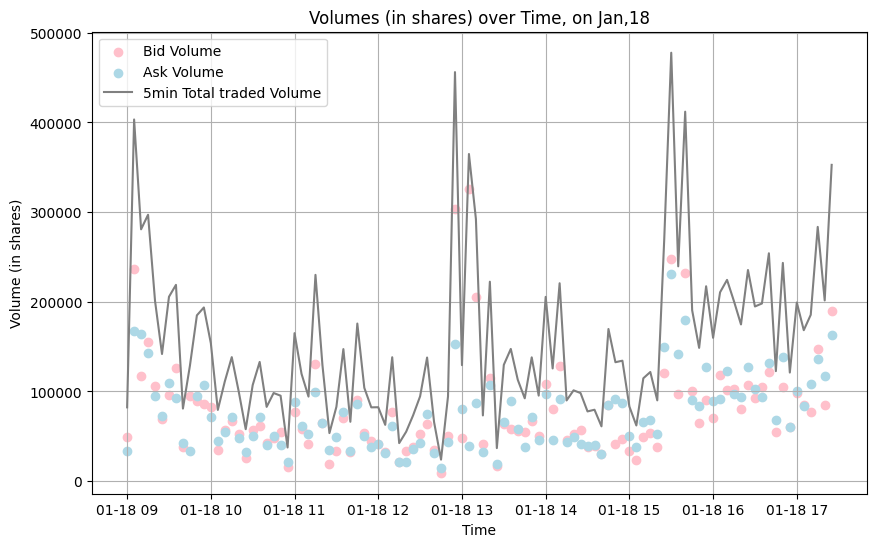

In [8]:
# We shall now analyze the volume profile of the order book on a random day

#### params ####
start_time = pd.Timestamp("2017-01-18 09:00:00")
end_time = pd.Timestamp("2017-01-18 17:30:00")
freq = '5min'
################
## filter on actual trades T and M.
subset_df = filename_df[(filename_df['ets'] >= start_time) &  
                        (filename_df['ets'] <= end_time) & 
                        (filename_df['etype'].isin(['T']))]
subset_df = subset_df.set_index('ets')
subset_df = subset_df[['bq0', 'aq0']].resample(freq).sum()
subset_df['ets'] = subset_df.index

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(subset_df['ets'], subset_df['bq0'], color = "pink", label="Bid "
                                                                    "Volume")
ax1.scatter(subset_df['ets'], subset_df['aq0'], color = "lightblue", 
            label="Ask Volume")
ax1.plot(subset_df['ets'], subset_df['aq0']+subset_df['bq0'], color = 
"gray", label=freq + " Total traded Volume")

ax1.set_xlabel("Time")
ax1.set_ylabel("Volume (in shares)")

ax1.legend(loc='upper left')
(plt.title("Volumes (in shares) over Time, on " +  str(start_time.strftime("%b")) +"," +
           str(start_time.day)))
plt.grid(True)
plt.show()


Comments : We see the typical U shape of the volume, with a peak at the 
beginning and at the end of the day. Plus, we see that the volume traded is 
reaching another peak around 13:00, which is a bit uncommon and can be 
related to some news or events that happened during the day. We also see the 
US opening at 15:30, where the volume traded is increasing.

In [9]:
# Measurement of the tick size
tick_a = filename_df['ap0'].diff().abs().loc[lambda x: x != 0].min()
tick_b = filename_df['bp0'].diff().abs().loc[lambda x: x != 0].min()
tick = min(tick_a, tick_b)
print(f"The (observed) tick size is: {tick}")
## we check that all prices are multiple of the tick size
sanity_check_a = (filename_df['ap0'] % tick).sum()
sanity_check_b = (filename_df['bp0'] % tick).sum()
sanity_check_e = (filename_df['eprice'] % tick).sum()
if sanity_check_a == 0 and sanity_check_b == 0 and sanity_check_e == 0:
    print("All prices are multiples of the tick size")
else:
    print("Not all prices are multiples of the tick size:")
    print(f"Ask prices: {sanity_check_a}")
    print(f"Bid prices: {sanity_check_b}")
    print(f"Exec prices: {sanity_check_e}")

The (observed) tick size is: 5.0
All prices are multiples of the tick size


Comments : The tick size must not be too large in order to allow sufficient 
granularity of prices and not too small in order to limit the competition on 
price priority. Plus, we have checked that, indeed, the prices are multiples
of the tick size. Note that if the data is indeed related to the SG stock, 
then all prices are expressed in 10e-3 euro, as the SG stock price was around
45 euro in 2018, and our data is around 45000. 

In [10]:
# Question 3 : Distribution of the order sizes and of the duration of the trades
# 3.1. Order sizes
order_sizes = filename_df[filename_df['etype'].isin(['T'])]['eqty'].abs()

# --- Exponential law for comparison Y-axis ---
n_obs = len(order_sizes)
lamb = 1/order_sizes.mean()
points = numpy.linspace(1, 10000, 2000)
exponential_law = [lamb*numpy.exp(-lamb*x) for x in points]
# --- Power law for comparison Y-axis ---
pl_fit = powerlaw.Fit(order_sizes, discrete=True)  
alpha = pl_fit.alpha
x_min = pl_fit.xmin
points_pl = numpy.logspace(numpy.log10(x_min), numpy.log10(10000), 1000)
C = (alpha - 1) / (x_min ** (alpha - 1))
powerlaw_pdf = C * (points_pl ** (-alpha))

Calculating best minimal value for power law fit


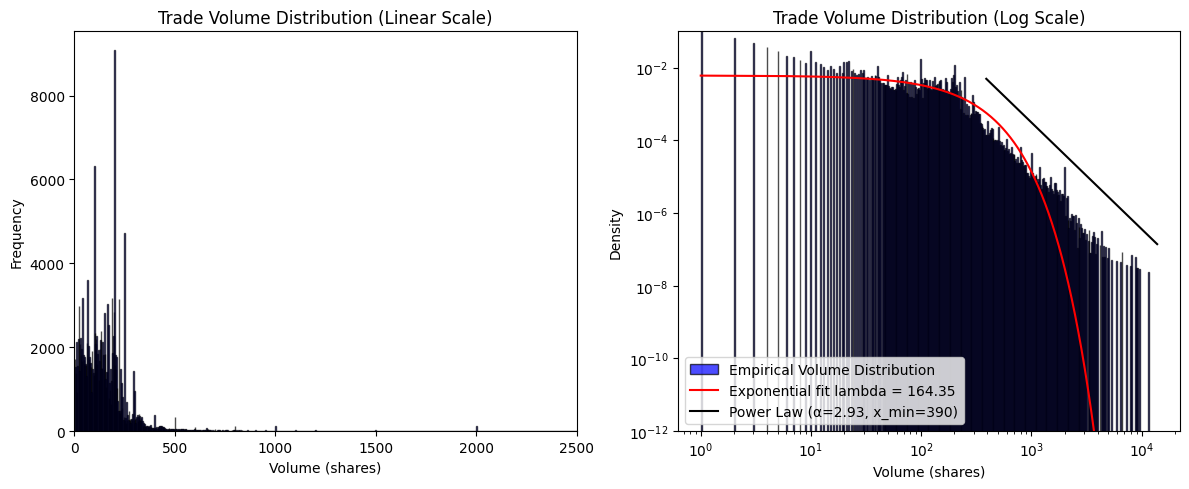

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

min_val = order_sizes.min()
max_val = order_sizes.max()
num_bins = 500  # choose how many bins you want
bins = numpy.logspace(numpy.log10(min_val), numpy.log10(max_val), num_bins)
# --- Left Plot: Linear Scale ---
axes[0].hist(order_sizes, bins=10*num_bins, color='blue', edgecolor='black', 
             alpha=0.7)
axes[0].set_title('Trade Volume Distribution (Linear Scale)')
axes[0].set_xlim(0,2500)
axes[0].set_xlabel('Volume (shares)')
axes[0].set_ylabel('Frequency')
# --- Right Plot: Logarithmic Y-axis ---
axes[1].hist(order_sizes, bins=bins, 
             color='blue', edgecolor='black',
             alpha=0.7, log=True, 
             density=True,  
             label='Empirical Volume Distribution')
axes[1].plot(points,exponential_law, 
             color='red', label='Exponential fit lambda = {:.2f}'.format
    (1/lamb))
pl_fit.power_law.plot_pdf(ax=axes[1], color='black', linestyle='-',
                          label=f'Power Law (α={alpha:.2f}, x_min={x_min:.0f})')

axes[1].set_title('Trade Volume Distribution (Log Scale)')
axes[1].set_xlabel('Volume (shares)')
axes[1].set_ylabel('Density')
axes[1].set_xscale('log')
axes[1].set_ylim(1e-12, 1e-1)
axes[1].legend(loc='lower left')
plt.tight_layout()
plt.show()

Comments : The above graphs represent the distribution of trade volumes, on 
a linear scale on the left and on a log scale on the right. We can note that
the linear scale histogram shows a majority of trades occuring at lower  
volumes, with a sharp peak near zero and a rapid decrease as volume increases
. Small trades seem more frequent than large ones. To better observe the 
distribution of the trade volumes, we decided to plot it on a log scale. 

The empirical volume distribution shows a heavy-tail pattern, with heavier 
tails than the exponential distribution fitted with a decay parameter of 261
.44 to capture the general trend. To account for the heaviest tails 
(representing extremely large trades, occuring with a significant 
probability even though most trades are small), we can fit a power-law that 
models better the tails behavior as displayed on the graph. 

Therefore, we can see the complexity of trade volume dynamics with both a 
prevalence of small trades and the potential for extreme events. 

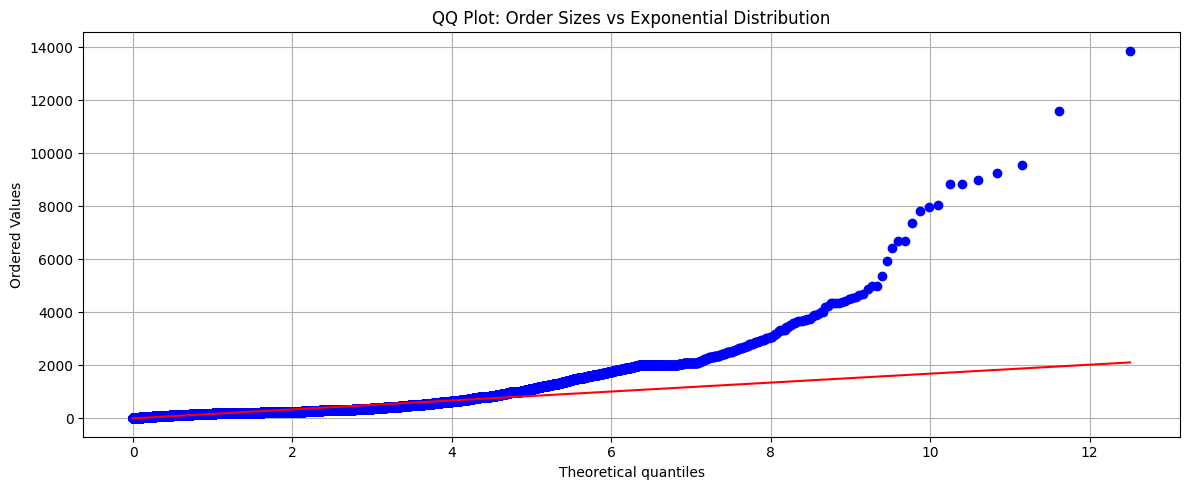

In [12]:
# We create a QQ plot
plt.figure(figsize=(12,5))
scipy.stats.probplot(order_sizes, dist="expon", plot=plt)
plt.title('QQ Plot: Order Sizes vs Exponential Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

Comments : This QQ-plot depicts the quantiles of the empirical distribution 
of order sizes (or the trade volumes) in function of the quantiles of the 
exponential distribution. We can see that the exponential distribution fails 
to explain the heavier tails of the distribution, renforcing our observation
made on the plot of the trade volume distribution that the empirical 
distribution has heavy tails. 

In [13]:
# 3.2. Duration of the trades
#### params ####
start_time = pd.Timestamp("2017-01-18 08:00:00")
end_time = pd.Timestamp("2017-01-18 18:00:00")
################

actual_exec_df = filename_df[(filename_df['ets'] >= start_time) &  
                        (filename_df['ets'] <= end_time) & 
                        (filename_df['etype'] == 'T')].copy()

actual_exec_df['duration'] = actual_exec_df['ets'].diff().dt.total_seconds()
durations = actual_exec_df['duration'].dropna()
# --- Exponential law for comparison Y-axis ---
n_obs = len(durations)
lamb = 1/durations.mean()
points = numpy.linspace(0, 100, 1000)
exponential_law = [lamb*numpy.exp(-lamb*x) for x in points]

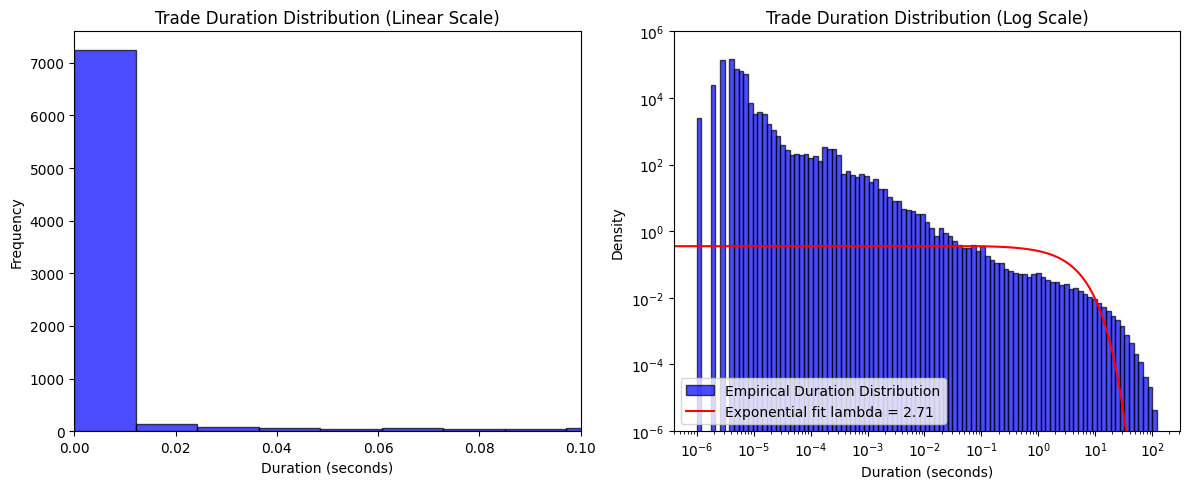

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

min_val = durations.min()
max_val = durations.max()
num_bins = 100  # choose how many bins you want
bins = numpy.logspace(numpy.log10(min_val), numpy.log10(max_val), num_bins)
# --- Left Plot: Linear Scale ---
axes[0].hist(durations, bins=10000, color='blue', edgecolor='black', 
             alpha=0.7)
axes[0].set_title('Trade Duration Distribution (Linear Scale)')
axes[0].set_xlim(0,0.1)
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Frequency')
# --- Right Plot: Logarithmic Y-axis ---
axes[1].hist(durations, bins=bins, 
             color='blue', edgecolor='black',
             alpha=0.7, log=True, 
             density=True,  
             label='Empirical Duration Distribution')
axes[1].plot(points,exponential_law, 
             color='red', label='Exponential fit lambda = {:.2f}'.format
    (1/lamb))

axes[1].set_title('Trade Duration Distribution (Log Scale)')
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Density')
axes[1].set_xscale('log')
axes[1].set_ylim(1e-6, 1e6)
axes[1].legend(loc='lower left')
plt.tight_layout()
plt.show()

Comments : Those two graphs illustrate the trade duration distribution, on a 
linear scale on the left and on a log scale on the right. We can see on the 
first graph that the vast majority of trades occur within a very short 
duration. Longer trade intervals are relatively rare as the frequency of 
occurence rapidly diminishes when the duration increases. When considering a 
log scale, we get a better view of the density of trade durations : shorter 
durations are more common but there is a non-negligible probability of 
encountering much longer durations. Indeed, the distribution has a heavy-tail
 pattern because it has a heavier tail than the exponential distribution used
  to fit the empirical distribution. Therefore, financial markets are 
  characterized by a predominance of trades with a short duration but with 
  occasional longer duration trades.  

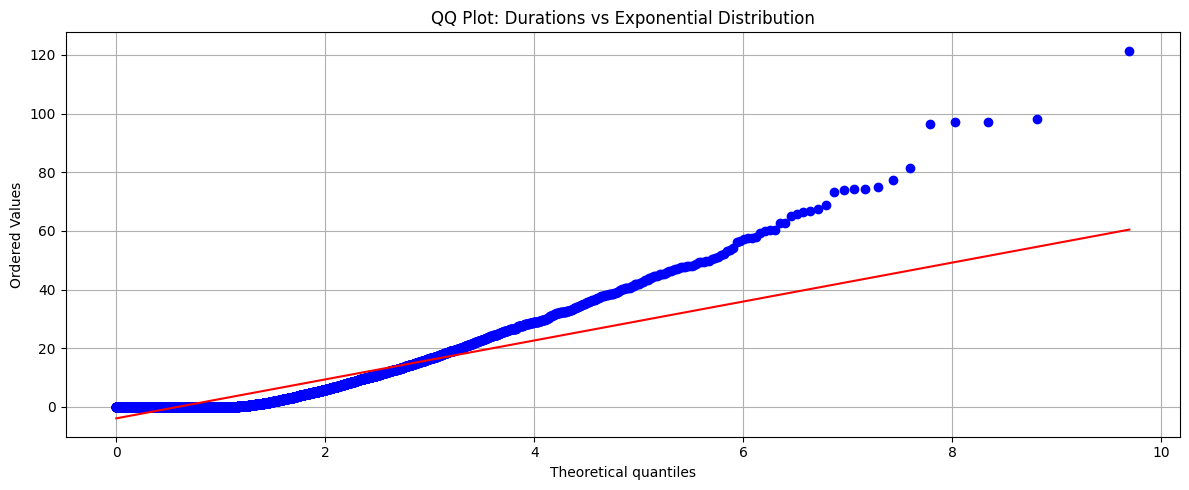

In [15]:
# We create a QQ plot
plt.figure(figsize=(12,5))
scipy.stats.probplot(durations, dist="expon", plot=plt)
plt.title('QQ Plot: Durations vs Exponential Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

Comments : This QQ-plot depicts the quantiles of the empirical distribution 
of trade durations in function of the quantiles of the exponential 
distribution. We can see that the exponential distribution fails to explain 
the heavier tails of the distribution, renforcing our observation made on 
the plot of the trade durations distribution that the empirical distribution
has heavier tails than the exponentiel one. However, the points are not as 
far from the right line as for the previous QQ-plot which seems to indicate 
that the exponential law explains better the empirical distribution of trade
durations than the empirical distribution of trade sizes. 

Question 4 : Distribution of the spread

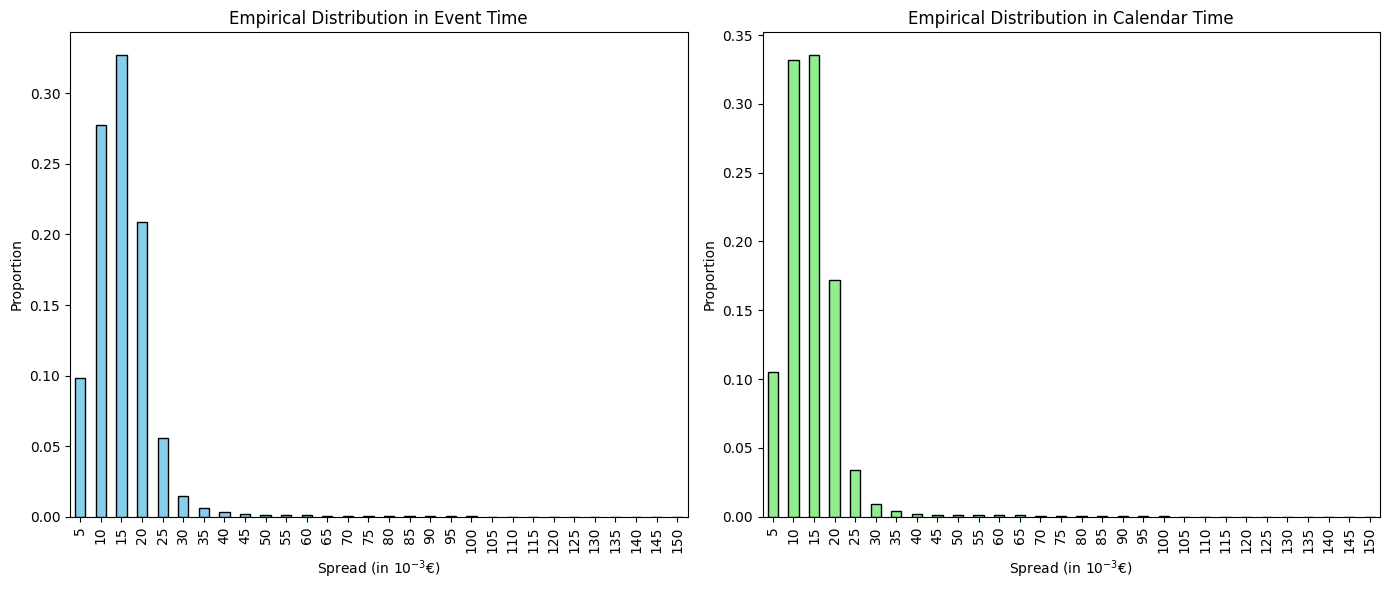

In [16]:
# Question 4

df = pd.DataFrame(filename_df)
event_time_distribution = df['spread'].value_counts(normalize=True).sort_index()


df['interval'] = df['ets'].diff().dt.total_seconds()
df['interval'] = numpy.where(df['interval'] < 30000, df['interval'], numpy.nan)
total_weight = df['interval'].sum()

calendar_time_distribution = (df.groupby('spread')['interval'].sum() / total_weight).sort_index()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

event_time_distribution.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
ax[0].set_title('Empirical Distribution in Event Time')
ax[0].set_xlabel('Spread (in $10^{-3}$€)')
ax[0].set_ylabel('Proportion')

calendar_time_distribution.plot(kind='bar', ax=ax[1], color='lightgreen', edgecolor='black')
ax[1].set_title('Empirical Distribution in Calendar Time')
ax[1].set_xlabel('Spread (in $10^{-3}$€)')
ax[1].set_ylabel('Proportion')

plt.tight_layout()
plt.show()

Comments : Those two graphs are the empirical distribution of the spreads in
event time on the left and in calendar time on the right. For the calendar 
time, we created an "interval" column by calculating the difference in 
seconds between consecutive timestamps. We set intervals greater than 30 000
seconds to NaN in order to remove intervals when the market is closed. The 
empirical distribution in calendar time was normalized by the sum of all 
 valid intervals. 

The left plot shows the distribution of the spread values in event time : it
focuses on the frequency of events at each spread. The graph indicates that 
most event occur at lower spreads, with a sharp decline when the spread 
increases. In terms of the number of events, tighter spreads are more common:
they correspond to periods of higher liquidity or more competitive market conditions. 

The right plot, in calendar time, focuses on the actuall time spent at each 
spread shows a slightly more spread out distribution, suggesting that there 
are periods where wider spreads can persist for longer durations, showing 
some periods of lower liquidity or higher market uncertainty. Those can be 
opportunities for market-making (as they can buy at a price lower than the 
price they can sell) or arbitrage strategies. 

Note that we have a rather large tick stock given the distribution of spreads.

Question 5 : Distribution of the log returns on different sampling frequencies

In [17]:
# Question 5
df_q5 = filename_df.copy()
df_q5

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,weighted_mid_price,spread
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445,46047.5,46053.160096,75
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445,46047.5,46053.160096,75
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445,46047.5,46053.160096,75
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445,46047.5,46053.160096,75
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445,46047.5,46053.160096,75
...,...,...,...,...,...,...,...,...,...,...,...,...
7827005,2017-02-01 17:29:59.286593,M,46005,0,B,46005,552,46030,640,46017.5,46018.422819,25
7827006,2017-02-01 17:29:59.287101,C,46030,230,S,46005,552,46030,410,46017.5,46015.654886,25
7827007,2017-02-01 17:29:59.529079,A,46055,167,S,46005,552,46030,410,46017.5,46015.654886,25
7827008,2017-02-01 17:29:59.543106,M,45085,0,B,46005,412,46030,410,46017.5,46017.469586,25


In [18]:
# Compute the log returns for a given sampling frequency
def compute_log_returns(df, freq):
    processing_df = df[df['etype'] == 'T'].copy()
    processing_df = processing_df.set_index('ets')
    processing_df = processing_df['eprice'].resample(freq).last()
    log_returns = numpy.log(processing_df/processing_df.shift(1))
    log_returns.rename('log_returns', inplace=True)
    log_returns.dropna(inplace=True)
    return log_returns

Normality test statistic: 84.49417650306393
p-value: 4.490789472465283e-19
We reject the gaussian hypothesis

Jarque-Bera statistic: 289.23946296471746
p-value: 1.5575738343937855e-63
Jarque-Bera test shows that fat tails and / or skewdness differ from Gaussian law


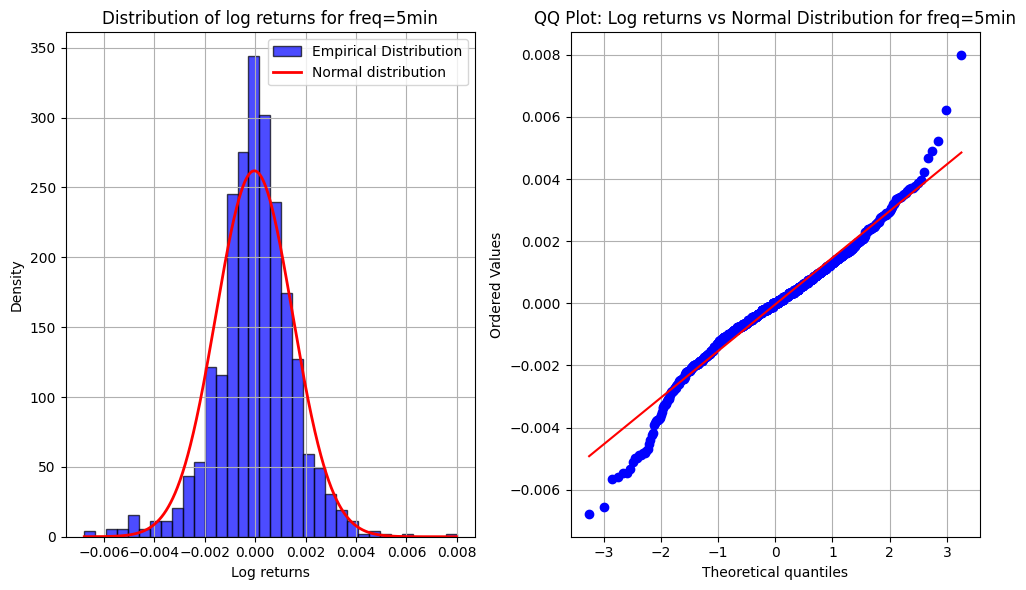

In [19]:
# Testing if the log returns are gaussian for an exemple
# --- params --- #
freq = '5min'
##################
log_returns = compute_log_returns(df_q5, freq)

# Statistical test for normality, skew and fat tails / kurtosis: D'Agostino-Pearson 
# and Jarque-Bera tests
stat, p_value = scipy.stats.normaltest(log_returns)
print("Normality test statistic:", stat)
print("p-value:", p_value)
if p_value > 0.05:
    print("Cannot reject the gaussian hypothesis\n")
if p_value < 0.05:
    print("We reject the gaussian hypothesis\n")
jb_stat, jb_p = scipy.stats.jarque_bera(log_returns)
print("Jarque-Bera statistic:", jb_stat)
print("p-value:", jb_p)
if jb_p < 0.05:
    print("Jarque-Bera test shows that fat tails and / or skewdness differ from Gaussian law")
if jb_p > 0.05:
    print("Jarque-Bera test cannot say that fat tails and / or skewdness differ from Gaussian law")

# --- Gaussian law for comparison ---
mu = log_returns.mean()
sigma = log_returns.std()
x = numpy.linspace(log_returns.min(), log_returns.max(), 1000)
pdf = scipy.stats.norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].hist(log_returns, bins=int(numpy.sqrt(len(log_returns))), color='blue', 
        edgecolor='black', 
             alpha=0.7, label='Empirical Distribution', density=True)
ax[0].plot(x, pdf, 'r-', lw=2, label='Normal distribution')
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Distribution of log returns for freq=' + freq)
ax[0].set_xlabel('Log returns')
ax[0].set_ylabel('Density')
# Right subplot: QQ plot
scipy.stats.probplot(log_returns, dist="norm", plot=ax[1])
ax[1].set_title('QQ Plot: Log returns vs Normal Distribution for freq=' + freq)
ax[1].grid(True)

plt.tight_layout()
plt.show()

Comments : This print and the plots are used to assess whether the log returns data follows a Gaussian distribution. The very low p-value of the Normality test shows strong evidence to reject the null hypothesis, under which the data is normally distributed. Then, the Jarque-Bera test, checking for normality by assessing skewness and kurtosis displays an extremely low p-value. It indicates deviations from normality and therefore the presence of fat tails and / or skewness in the data. 

The first plot is an histogram distribution of log returns for a choosen frequency of 5 minutes, with a normal distribution overlay. The empirical distribution has a higher peak and heavier tails compared to the normal distribution showing potential deviations from normality. This is confirmed by the QQ-plot comparing the quantiles of the log returns data against the quantiles of a normal distribution : deviations from the red line in the tails suggest heavier tails than a normal distirbution. 

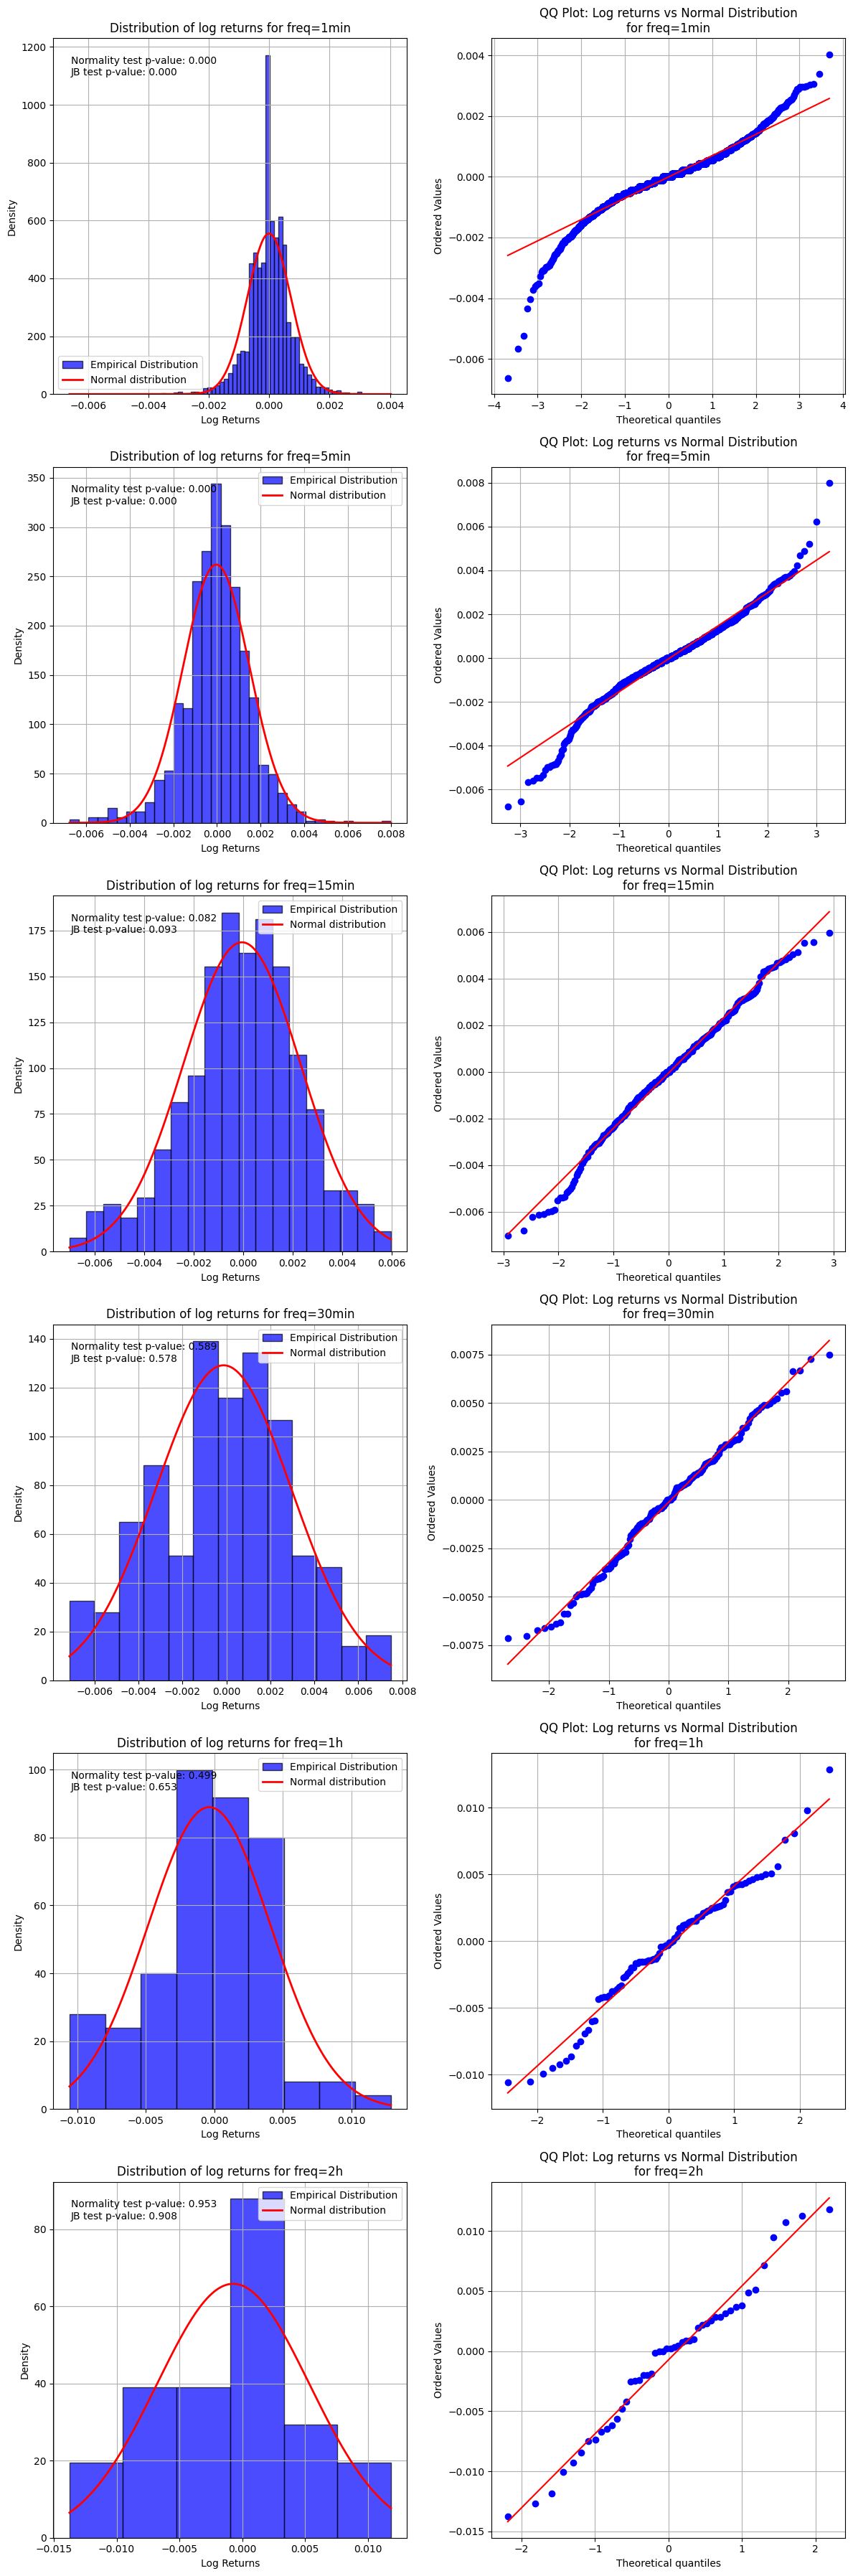

In [20]:
## we now generalize this exemple to several frequencies
# List of frequency strings you want to analyze
freqs = ["1min",'5min', '15min', "30min", '1h',"2h"]

fig, ax = plt.subplots(len(freqs), 2, figsize=(12, 6 * len(freqs)))
if len(freqs) == 1:
    ax = numpy.array([ax])
    
#copy paste of before + adding the tests inside the plots
for i, freq in enumerate(freqs):
    log_returns = compute_log_returns(df_q5, freq)
    #  Tests
    stat, p_value = scipy.stats.normaltest(log_returns)  
    jb_stat, jb_p = scipy.stats.jarque_bera(log_returns)

    # Gaussian  
    mu = log_returns.mean()
    sigma = log_returns.std()
    x = numpy.linspace(log_returns.min(), log_returns.max(), 1000)
    pdf = scipy.stats.norm.pdf(x, mu, sigma)
    
    # Left subplot: Histogram 
    ax[i, 0].hist(log_returns, bins=int(numpy.sqrt(len(log_returns))),
                  color='blue', edgecolor='black', alpha=0.7,
                  density=True, label='Empirical Distribution')
    ax[i, 0].plot(x, pdf, 'r-', lw=2, label='Normal distribution')
    ax[i, 0].legend()
    ax[i, 0].grid(True)
    ax[i, 0].set_title(f'Distribution of log returns for freq={freq}')
    ax[i, 0].text(0.05, 0.95,
    f"Normality test p-value: {p_value:.3f}\nJB test p-value: "f"{jb_p:.3f}",
    transform=ax[i, 0].transAxes, verticalalignment='top')
    ax[i, 0].set_xlabel('Log Returns')
    ax[i, 0].set_ylabel('Density')
    
    # Right subplot: QQ Plot
    scipy.stats.probplot(log_returns, dist="norm", plot=ax[i, 1])
    ax[i, 1].set_title(f'QQ Plot: Log returns vs Normal Distribution\nfor '
                       f'freq={freq}')
    ax[i, 1].grid(True)

plt.tight_layout()
plt.show()

Comments : The series of plots have been made to compare the log return 
distributions across different frequencies, ranging from 1 minute to 2 hours.
One specific frequency is displayed per row of this figure. On the left, the 
empirical distribution is again overlayed with the normal distribution and 
on the right, a QQ-plot compares the log returns to a normal distribution, 
to confirm the conclusions that could be drawn out of the left plot. 

Overall, across all frequencies, the histograms reveal that the empirical 
distributions of log returns exhibit higher peaks and heavier tails compared
to the normal distribution. However, those characteristics are more obvious
in the shorter time frames, in the 1-min and 5-min intervals : deviations 
from normality are more pronounced and arre confirmed by the two 
statistical tests. When the frequences increases to 15-min, 30-min, 1h and
2h, the distributions begin to align more and more to the normal 
distribution, even though some deviations remain in the tails as seen on 
the QQ-plots. But the statistical tests exhibit p-values that doesn't 
enable us to reject the null hypothesis anymore. 

Therefore, in calendar time, the Gaussian hypothesis is not satisfied !

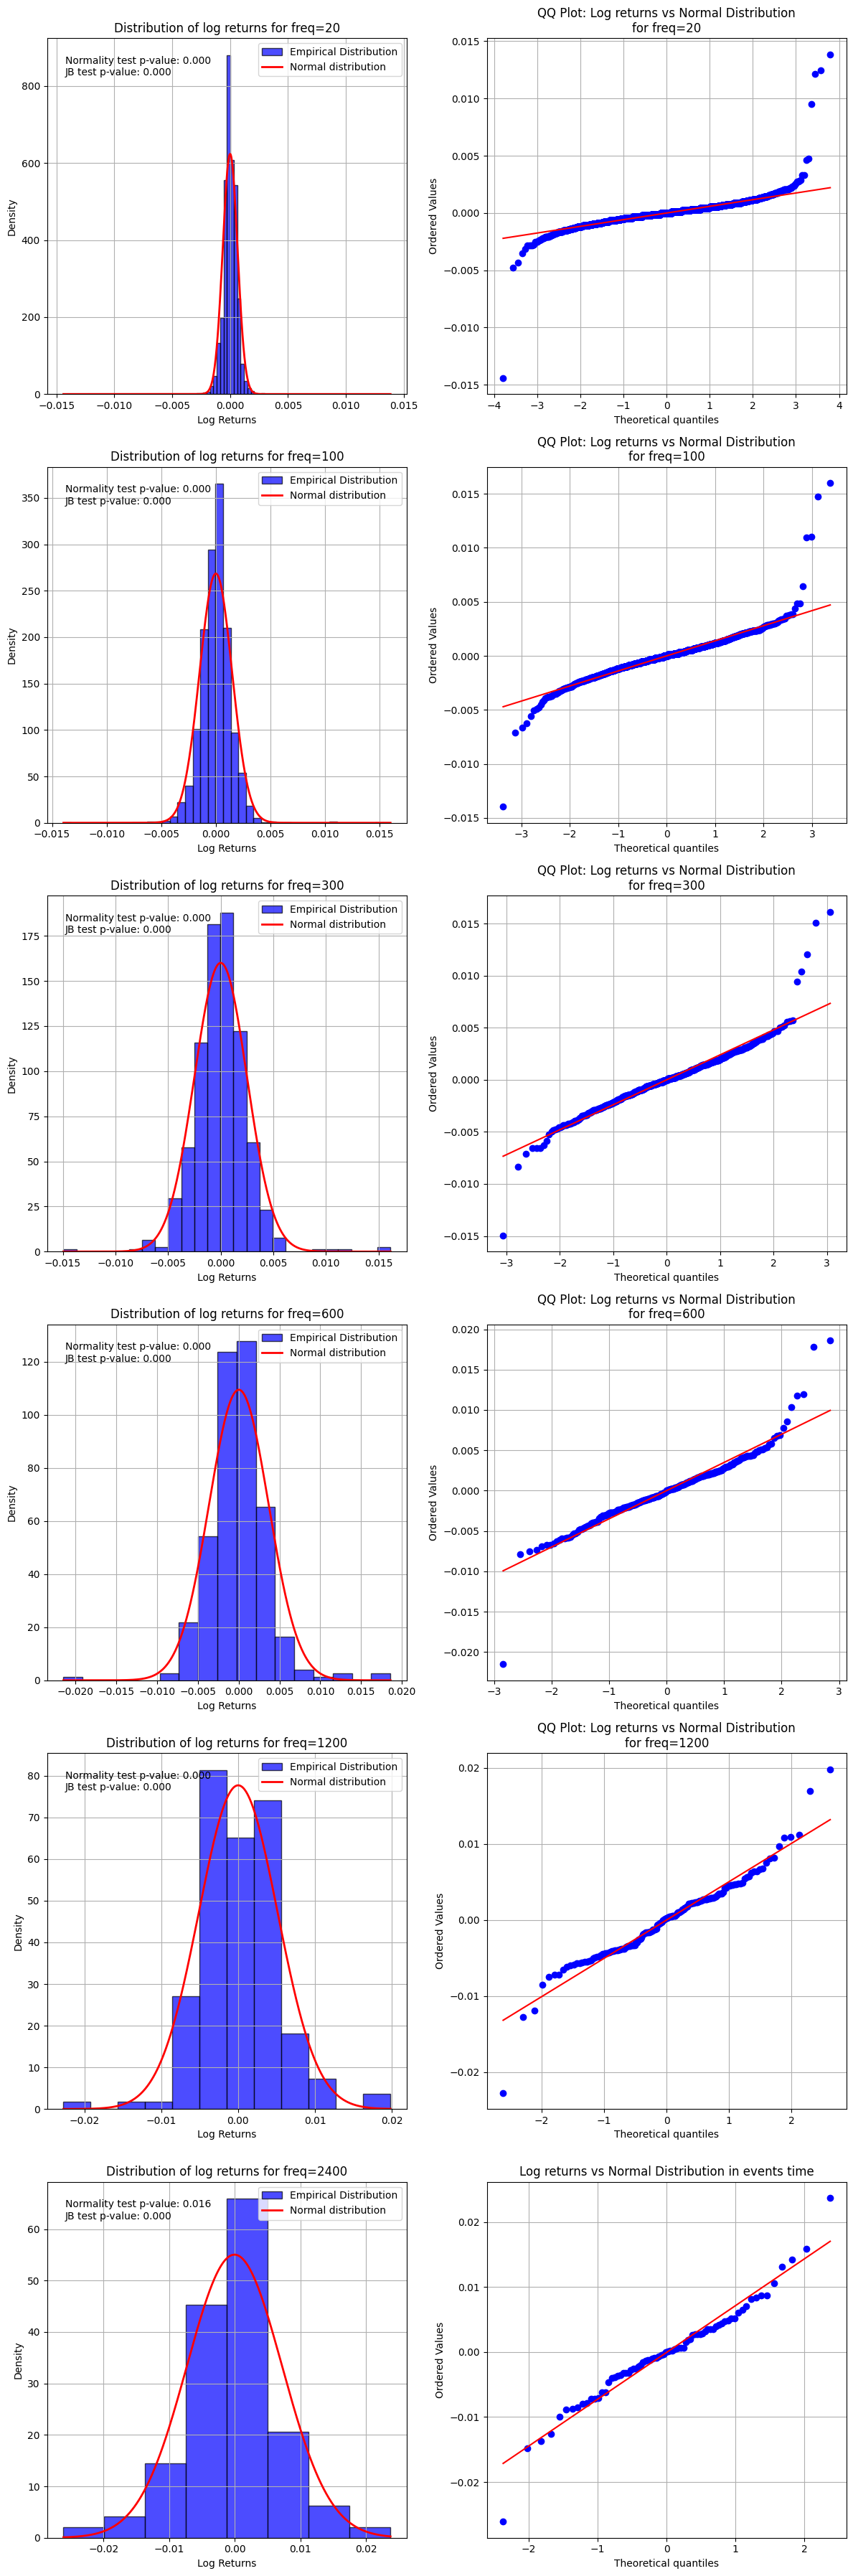

In [21]:
## we now try using the event time instead of the calendar time
# List of frequency of events to resample
## we now generalize this exemple to several frequencies
# List of frequency strings you want to analyze
## note that we use the result of question 3 where we found that the average 
# duration is of the order of 1 second (2.7s actually)
# thus, 1min is in average approx 20 events
freqs = [20, 100, 300, 600, 1200, 2400]
# corresponding in average to the previous ["1min",'5min', '15min', "30min",
# '1h',"2h"]


fig, ax = plt.subplots(len(freqs), 2, figsize=(12, 6 * len(freqs)))
if len(freqs) == 1:
    ax = numpy.array([ax])


def compute_log_returns_calendar(df, freq):
    processing_df = df[df['etype'] == 'T'].copy()
    processing_df.reset_index(drop=True, inplace=True)
    processing_df['group'] = processing_df.index // freq
    grouped_prices = processing_df.groupby('group')['eprice'].last()
    log_returns = numpy.log(grouped_prices / grouped_prices.shift(1))
    log_returns.rename('log_returns', inplace=True)
    log_returns.dropna(inplace=True)
    return log_returns


#copy paste of before + adding the tests inside the plots + changing the 
# resampling technique
for i, freq in enumerate(freqs):
    log_returns = compute_log_returns_calendar(df_q5, freq)
    #  Tests
    stat, p_value = scipy.stats.normaltest(log_returns)
    jb_stat, jb_p = scipy.stats.jarque_bera(log_returns)

    # Gaussian  
    mu = log_returns.mean()
    sigma = log_returns.std()
    x = numpy.linspace(log_returns.min(), log_returns.max(), 1000)
    pdf = scipy.stats.norm.pdf(x, mu, sigma)

    # Left subplot: Histogram 
    ax[i, 0].hist(log_returns, bins=int(numpy.sqrt(len(log_returns))),
                  color='blue', edgecolor='black', alpha=0.7,
                  density=True, label='Empirical Distribution')
    ax[i, 0].plot(x, pdf, 'r-', lw=2, label='Normal distribution')
    ax[i, 0].legend()
    ax[i, 0].grid(True)
    ax[i, 0].set_title(f'Distribution of log returns for freq={freq}')
    ax[i, 0].text(0.05, 0.95,
                  f"Normality test p-value: {p_value:.3f}\nJB test p-value: "f"{jb_p:.3f}",
                  transform=ax[i, 0].transAxes, verticalalignment='top')
    ax[i, 0].set_xlabel('Log Returns')
    ax[i, 0].set_ylabel('Density')

    # Right subplot: QQ Plot
    scipy.stats.probplot(log_returns, dist="norm", plot=ax[i, 1])
    ax[i, 1].set_title(f'QQ Plot: Log returns vs Normal Distribution\nfor '
                       f'freq={freq}')
    ax[i, 1].grid(True)
plt.title('Log returns vs Normal Distribution in events time')
plt.tight_layout()
plt.show()

With this experiment, we reproduce the previous calendar frequencies (in 
average) in event time. We can see that the normality tests are this time 
significant for all frequencies, which shows that the log returns are never 
Gaussian in event time. The QQ-plots also show that the some returns are 
quite different from the normal distribution, especially because of the 
extreme ones. 

Question 6 : Study of the imbalance and its prediction properties

In [22]:
# Question 6
df_q6 = filename_df.copy()
df_q6['imbalance'] = (df_q6['bq0'] - df_q6['aq0']) / (df_q6['aq0'] +
                                                      df_q6['bq0'])
df_q6

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,weighted_mid_price,spread,imbalance
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445,46047.5,46053.160096,75,-0.150936
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445,46047.5,46053.160096,75,-0.150936
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445,46047.5,46053.160096,75,-0.150936
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445,46047.5,46053.160096,75,-0.150936
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445,46047.5,46053.160096,75,-0.150936
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7827005,2017-02-01 17:29:59.286593,M,46005,0,B,46005,552,46030,640,46017.5,46018.422819,25,-0.073826
7827006,2017-02-01 17:29:59.287101,C,46030,230,S,46005,552,46030,410,46017.5,46015.654886,25,0.147609
7827007,2017-02-01 17:29:59.529079,A,46055,167,S,46005,552,46030,410,46017.5,46015.654886,25,0.147609
7827008,2017-02-01 17:29:59.543106,M,45085,0,B,46005,412,46030,410,46017.5,46017.469586,25,0.002433


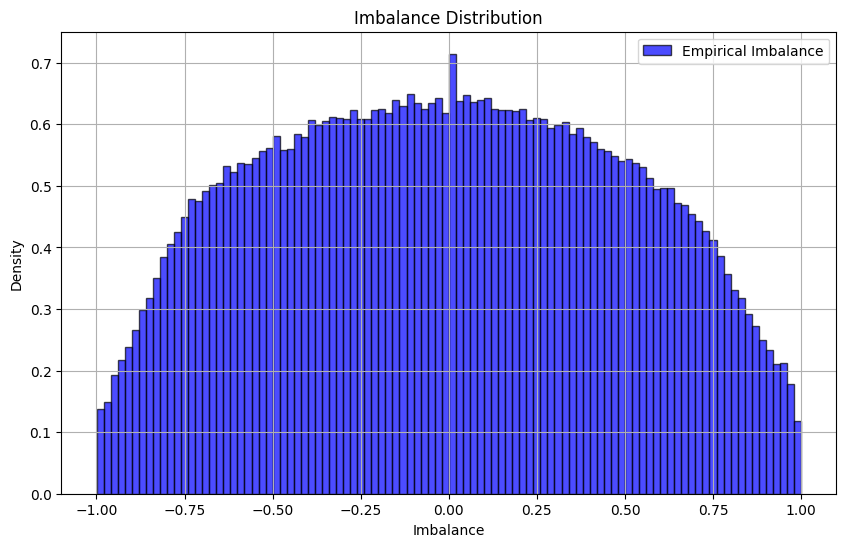

In [23]:
# vizualisation of the imbalance
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_q6['imbalance'], bins=100, color='blue',
                            edgecolor='black', alpha=0.7, density=True,
                            label='Empirical Imbalance')

plt.title('Imbalance Distribution')
plt.xlabel('Imbalance')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

Comments : This histogram illustrates the empirical distribution of 
imbalances that appears roughly symmetric around zero. It suggests that 
imbalance is evenly spread between negative and positive values. But there 
is a noticeable peak near zero, meaning that small inbalances are more 
frequent. The peak and some heavier tails than the normal distribution shows 
the presence of more extreme imbalance values than expected under normality. 
 Therefore, there are occasionally significant deviations.

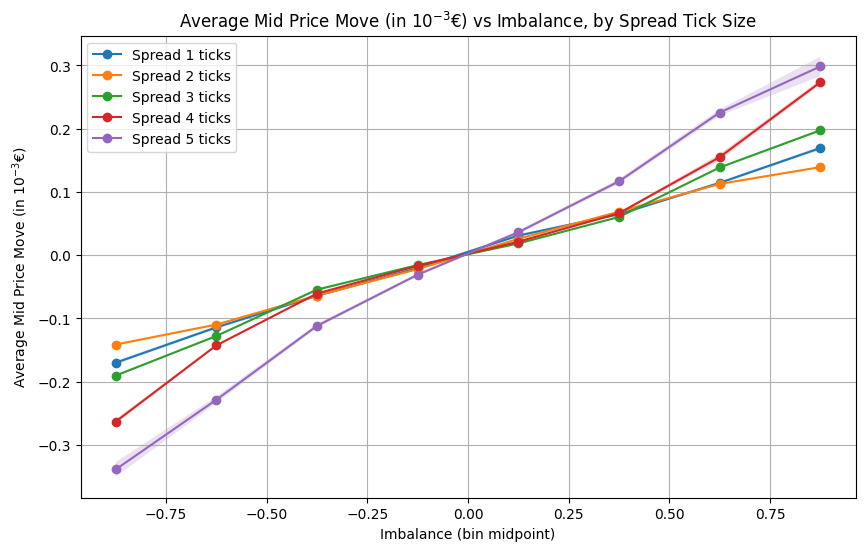

In [24]:
bins = numpy.arange(-1.0, 1.01, 0.25)

df_q6['imbalance_group'] = pd.cut(df_q6['imbalance'], bins=bins)
df_q6['spread_tick_size'] = df_q6['spread'] // 5
df_q6['mid_price_move'] = df_q6['mid_price'].diff().shift(-1)

average_mid_price_move = (
    df_q6.groupby(['imbalance_group', 'spread_tick_size'], observed=False)
    ['mid_price_move'].mean())

std_mid_price_move = (
    df_q6.groupby(['imbalance_group', 'spread_tick_size'], observed=False)
    ['mid_price_move'].std())

n_series = df_q6.groupby(['imbalance_group', 'spread_tick_size'], 
                          observed=False)['mid_price_move'].size() 

df_pivot_mean = average_mid_price_move.unstack('spread_tick_size')
df_pivot_std  = std_mid_price_move.unstack('spread_tick_size')
df_pivot_n = n_series.unstack('spread_tick_size')

plt.figure(figsize=(10, 6))

spreads_to_plot = [1,2, 3,4, 5]

for spread in spreads_to_plot:
    counts_series = df_pivot_n[spread].dropna()

    mean_series = df_pivot_mean[spread].dropna()
    std_series  = df_pivot_std[spread].dropna()

    x_values = [interval.mid for interval in mean_series.index]
    y_values = mean_series.values
    y_errors = std_series.values / numpy.sqrt(counts_series.values)

    plt.plot(x_values, y_values, marker='o', label=f"Spread {spread} ticks")
    plt.fill_between(x_values,
                     y_values - y_errors,
                     y_values + y_errors,
                     alpha=0.2)

plt.title('Average Mid Price Move (in $10^{-3}$€) vs Imbalance, by Spread Tick Size')
plt.xlabel('Imbalance (bin midpoint)')
plt.ylabel('Average Mid Price Move (in $10^{-3}$€)')
plt.grid(True)
plt.legend()
plt.show()

Comments : This graph illustrates the relationship between the average 
mid-price and imbalance across different spread tick sizes, going from 1 
tick to 5 ticks. On the x-acis, we represented the imbalance in terms of bin
midpoint, as we created some bins to group the imbalances into. We can see a
general trend where the average mid-price move increases as the imbalance 
becomes more positive. The spread of 5 ticks exhibits the steepest increase,
which suggests a more pronounced sensitivity to imbalance compared to small 
spreads. The smaller spreads show a more gradual response to changes in 
imbalance. This shows the impact of spread size on market dynamics. Also, 
the standard deviation is a little bit higher for larger ticks, as a proof 
that the change in the average mid-price is more uncertain as for smaller ticks. 

In the overall, for all tick sizes, it is possible to determine uniquely the
mid-price move associated, showing that the imabalance is a good predictor 
of the mid-price move. Let's now do the same study for the trade sign. 

We now will define the signs of trades and LOB events according to different 
convnetions. First, we will check that the 'eside' column well defines the 
sign of trades as we expect them to be: +1 for a trade executed at ask, -1 
for a trade executed at bid.

In [25]:
df_q6["trade_sign"]=numpy.where((df_q6['eside'] == 'S'),-1,numpy.where(
    (df_q6['eside'] == 'B'),1,0))

# First, compute the simple classification based on quotes
df_q6['trade_sign_quote'] = numpy.where(
    (df_q6['etype'] == 'T') & (df_q6['eprice'] <= df_q6['ap0']) &
    (df_q6['eprice'] > df_q6['bp0']),
    -1,
    numpy.where(
        (df_q6['etype'] == 'T') & (df_q6['eprice'] >= df_q6['bp0']) &
        (df_q6['eprice'] < df_q6['ap0']),
        +1,
        0)
)

# Now compute the tick test: difference with previous execution price
df_q6['prev_eprice'] = df_q6['eprice'].shift(1)
df_q6['tick'] = df_q6['eprice'] - df_q6['prev_eprice']

# Define the tick test classification: +1 if tick > 0, -1 if tick < 0, and 0 if no change
df_q6['trade_sign_tick'] = numpy.where(df_q6['tick'] > 0, 1,
                               numpy.where(df_q6['tick'] < 0, -1, 0))

# Combine the two methods:
# For trades clearly at the boundaries, use the quote-based sign;
# for trades inside the spread, use the tick test.
df_q6['trade_sign_recomputed'] = numpy.where(
    (df_q6['etype'] == 'T') & 
    (df_q6['eprice'] > df_q6['bp0']) & (df_q6['eprice'] < df_q6['ap0']),
    df_q6['trade_sign_tick'],
    df_q6['trade_sign_quote']
)

df_q6['sign_next_trade'] = numpy.sign(df_q6['trade_sign'].shift(-1))

df_q6['check_trade_sign'] = df_q6['trade_sign'] - df_q6['trade_sign_recomputed']

## we analyse where our definition differs from the dataset
print(df_q6.loc[(df_q6['etype']=='T')][['check_trade_sign']].value_counts())
df_q6.loc[(df_q6['etype']=='T') & (df_q6['check_trade_sign']!=0)].head(10)

check_trade_sign
 0                  137879
 1                   17571
-1                   17429
-2                    7366
 2                    7316
Name: count, dtype: int64


,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0,mid_price,...,spread_tick_size,mid_price_move,trade_sign,trade_sign_quote,prev_eprice,tick,trade_sign_tick,trade_sign_recomputed,sign_next_trade,check_trade_sign
35,2017-01-17 09:01:08.420222,T,46080,90,B,46010,1339,46085,1445,46047.5,...,15,0.0,1,-1,46080.0,0.0,0,0,1.0,1
53,2017-01-17 09:01:08.444769,T,46085,731,S,46010,855,46100,1000,46055.0,...,18,2.5,-1,-1,46085.0,0.0,0,0,1.0,-1
103,2017-01-17 09:01:08.639768,T,46080,88,B,46030,446,46100,1000,46065.0,...,14,0.0,1,-1,46080.0,0.0,0,0,-1.0,1
116,2017-01-17 09:01:08.663275,T,46070,20,B,46030,226,46100,1000,46065.0,...,14,-2.5,1,-1,46070.0,0.0,0,0,-1.0,1
460,2017-01-17 09:01:58.235501,T,46100,132,B,46090,642,46165,663,46127.5,...,15,0.0,1,-1,46100.0,0.0,0,0,1.0,1
463,2017-01-17 09:01:58.235513,T,46090,212,B,46085,200,46165,663,46125.0,...,16,-2.5,1,-1,46090.0,0.0,0,0,1.0,1
464,2017-01-17 09:01:58.235517,T,46085,200,B,46080,849,46165,663,46122.5,...,17,0.0,1,-1,46090.0,-5.0,-1,-1,1.0,2
467,2017-01-17 09:01:58.235527,T,46080,207,B,46075,200,46165,663,46120.0,...,18,-10.0,1,-1,46080.0,0.0,0,0,1.0,1
468,2017-01-17 09:01:58.235530,T,46075,200,B,46055,420,46165,663,46110.0,...,22,0.0,1,-1,46080.0,-5.0,-1,-1,1.0,2
471,2017-01-17 09:01:58.235540,T,46055,197,B,46050,214,46165,663,46107.5,...,23,-2.5,1,-1,46055.0,0.0,0,0,1.0,1


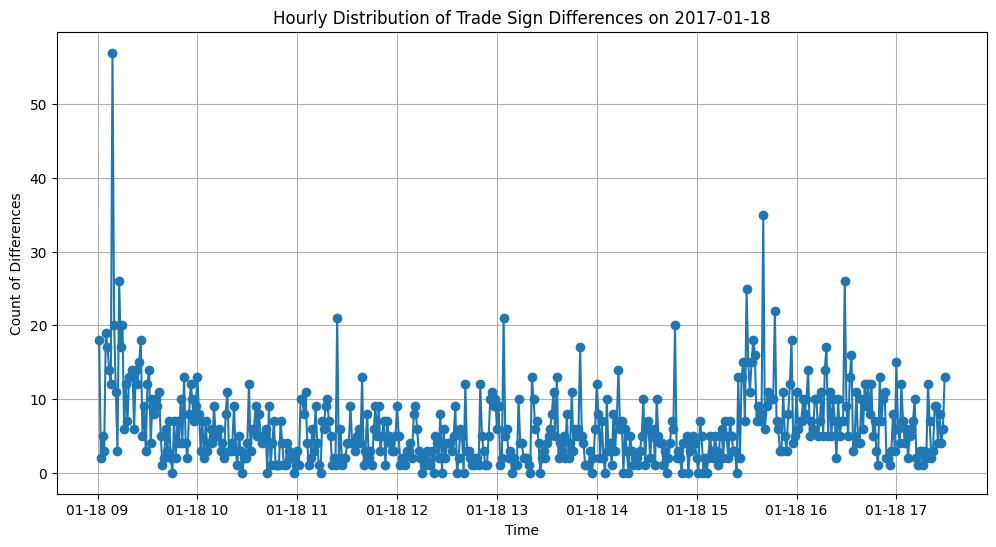

In [26]:
# Let us see when our definiton of trade sign differ with the dataset definiton
target_day = '2017-01-18'

df_diff = df_q6[(df_q6['etype'] == 'T') & (df_q6['check_trade_sign'] != 0)].copy()

df_diff['ets'] = pd.to_datetime(df_diff['ets'])

start_date = pd.to_datetime(target_day)
end_date = start_date + pd.Timedelta(days=1)

df_day = df_diff[(df_diff['ets'] >= start_date) & (df_diff['ets'] < end_date)]

df_day.set_index('ets', inplace=True)

hourly_diff_counts = df_day.resample('1min').size()

plt.figure(figsize=(12, 6))
plt.plot(hourly_diff_counts.index, hourly_diff_counts.values,
         marker='o', linestyle='-')
plt.title(f'Hourly Distribution of Trade Sign Differences on {target_day}')
plt.xlabel('Time')
plt.ylabel('Count of Differences')
plt.grid(True)
plt.show()

Comments: we defined out trade sign by combining the two methods of checking 
tick increments and checking if the trade is executed at bid or at
ask. However, we see that some ambiguities persist, as trades can be executed
strictly between bid and ask, and sometimes a buy order can be executed one 
tick below the ask and two ticks above the bid. This may happen when the 
spread exceeds several ticks. The tick test cannot solve all problems, and 
some persist all day long. Thus, we cannot recompute the sign only based 
on our price data, and will use the original dataset classification from now 
on. Except for LOB sign based not on price pressure but on the side affected 
on the order book, which we will redefine.

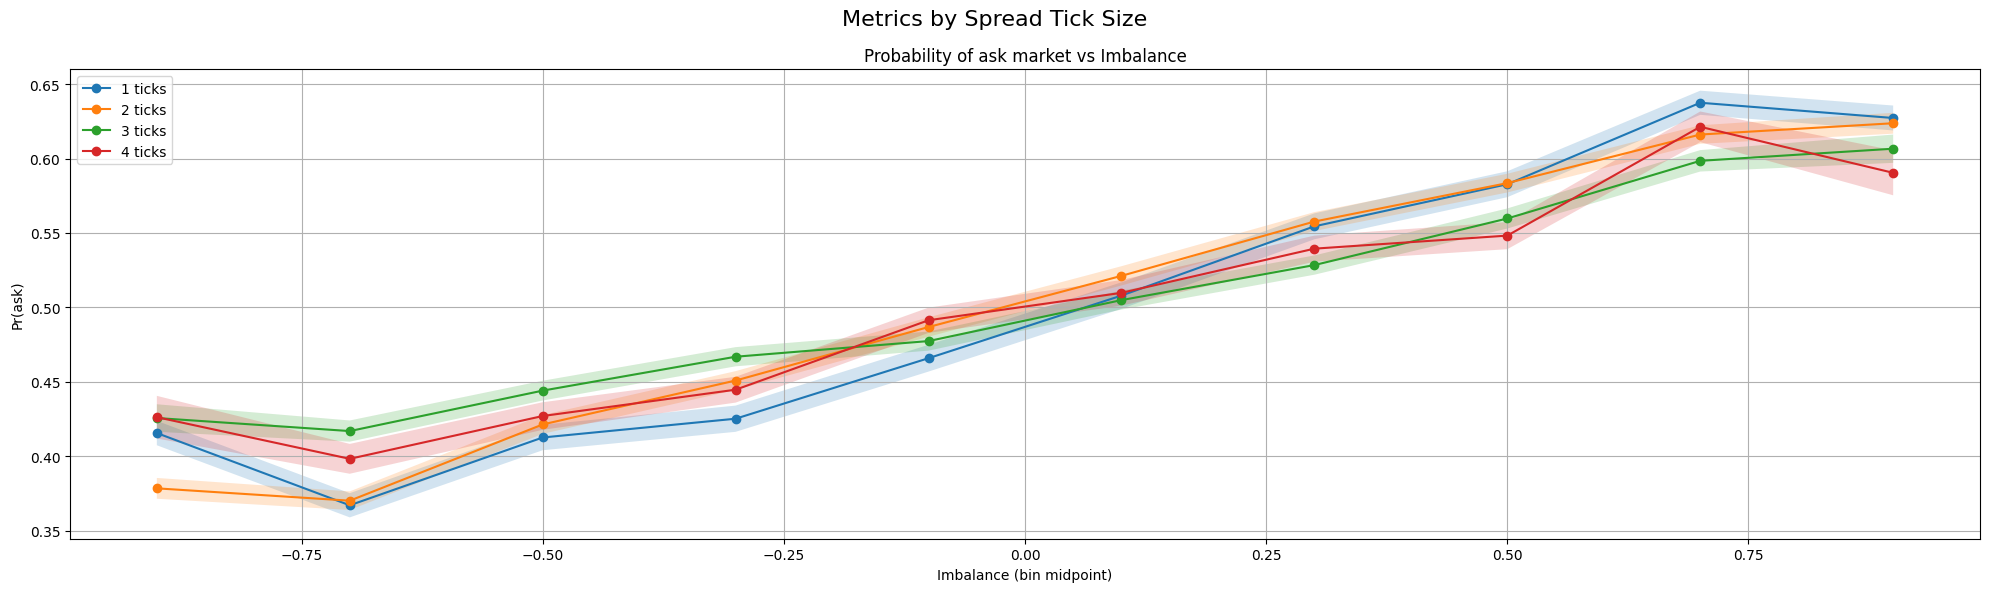

In [27]:
bins = numpy.arange(-1.0, 1.01, 0.2)
df_q6_trades = df_q6[(df_q6['etype'] == 'T')].copy()
df_q6_trades['imbalance_group'] = pd.cut(df_q6_trades['imbalance'], bins=bins)
df_q6_trades['next_is_buy'] = numpy.where(df_q6_trades['sign_next_trade'] == 
                                          -1,1,0)
proba_next_buy = df_q6_trades.groupby(['imbalance_group', 'spread_tick_size'], 
                         observed=False)['next_is_buy'].mean()
std_next_buy = df_q6_trades.groupby(['imbalance_group', 'spread_tick_size'], observed=False)['next_is_buy'].std()
n_series = df_q6_trades.groupby(['imbalance_group', 'spread_tick_size'], observed=False)['next_is_buy'].size()

df_pivot_mean = proba_next_buy.unstack('spread_tick_size')
df_pivot_std = std_next_buy.unstack('spread_tick_size')
df_pivot_n = n_series.unstack('spread_tick_size')

fig, ax1 = plt.subplots(1, 1, figsize=(20, 6))
spreads_to_plot = [1, 2, 3, 4]

for spread in spreads_to_plot:
    counts_series = df_pivot_n[spread].dropna()
    mean_series = df_pivot_mean[spread].dropna()
    std_series = df_pivot_std[spread].dropna()
    x_values = [interval.mid for interval in mean_series.index]
    y_values = mean_series.values
    y_errors = (std_series.values / numpy.sqrt(counts_series.values))
    ax1.plot(x_values, y_values, marker='o', label=f"{spread} ticks")
    ax1.fill_between(x_values, y_values - y_errors, y_values + y_errors, 
                      alpha=0.2)

ax1.set_xlabel('Imbalance (bin midpoint)')
ax1.set_ylabel('Pr(ask)')
ax1.set_title('Probability of ask market vs Imbalance')
ax1.grid(True)
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc='upper left')
plt.suptitle('Metrics by Spread Tick Size', fontsize=16)
plt.tight_layout()
plt.show()

Comments: we find as described in the course that ask market is much more 
likely for very positive imbalance. We furthermore can add with our work that
higher spreads tend to flatten the curve.

Question 7 : Sign the trades and analyze the autocorrelation function of 
this timeseries. Sign the LOB events depending the sign of their price 
pressure and analyze the autocorrelation function of this timeseries. Sign 
the LOB events depending the impacted side of the limit order book and 
analyze the autocorrelation function of this timeseries.

In [28]:
# Trades were already signed in the previous question. 
# Now we are going to analyse the autocorrelation function of this timeseries. 
# But to simplify our code, we are going to define one function to plot the autocorrelation
def plot_autocorrelation_logscale(time_series, legend='ACF', max_lag=10000):
    x = time_series.copy()
    lags = numpy.logspace(0, numpy.log10(max_lag), 50, dtype=int)
    autocorrelation = [x.corr(x.shift(-lag)) for lag in lags]
    plt.loglog(lags, autocorrelation, marker='x', linestyle='--', 
               label=legend)

Comments : we once again will use the trade sign available in the data for 
actual trades, but also for all LOB events (with price pressure convention), 
as a buy tends to push prices upwards and a sell downwards. If a buy order is
added or modified with positive quantity, then we affect 1. If a buy order is
executed, cancelled or modified with negative quantity, we affect -1. 
Reciprocally for sell events

In [29]:
df_q6['LOB_sign_price_pressure'] = numpy.where(
    (df_q6['eside'] == 'B') & (df_q6['etype'].isin(['A','M'])) 
    & (df_q6['eqty']> 0), 1,
    
    numpy.where(
    (df_q6['eside'] == 'B') & (df_q6['etype'].isin(['A','M'])) 
    & (df_q6['eqty']< 0), -1,
        
    numpy.where(
    (df_q6['eside'] == 'B') & (df_q6['etype'].isin(['T','C'])) 
    & (df_q6['eqty'] > 0), -1,
        
    ## reciprocally for sells    
    numpy.where(
    (df_q6['eside'] == 'S') & (df_q6['etype'].isin(['A','M'])) 
    & (df_q6['eqty']> 0), -1,
    
    numpy.where(
    (df_q6['eside'] == 'S') & (df_q6['etype'].isin(['A','M'])) 
    & (df_q6['eqty']< 0), +1,
        
    numpy.where(
    (df_q6['eside'] == 'S') & (df_q6['etype'].isin(['T','C'])) 
    & (df_q6['eqty']> 0), +1,
    
    0))))))

We now will define a trade sign according to the side affected on the LOB: +1
if the event affects the ask side and -1 if it affects the bid side, in terms
of liquidity regardless of the price or the side. If liquidity is added or 
removed from the bid side, we give +1, else -1. This is equivalent to take 
the 'eside' for all events of the order book

In [30]:
df_q6['LOB_sign_side'] = df_q6['trade_sign']

trade_sign
 1    94315
-1    93246
Name: count, dtype: int64


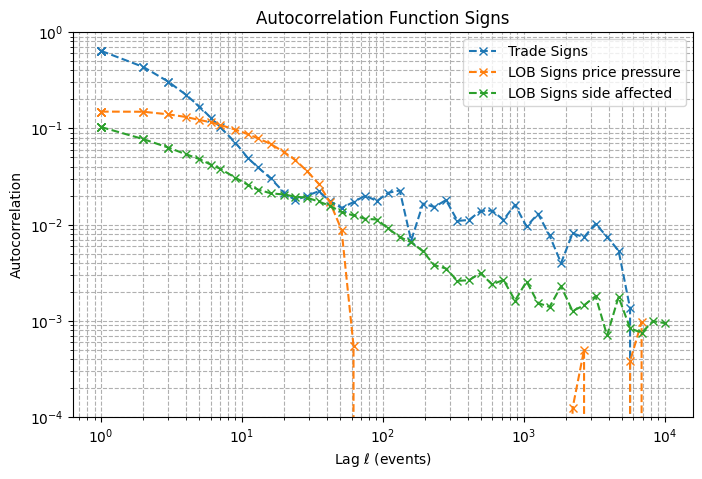

In [31]:
print(df_q6.loc[df_q6['etype']=='T']['trade_sign'].value_counts())

plt.figure(figsize=(8, 5))

plot_autocorrelation_logscale(df_q6.loc[df_q6['etype']=='T']['trade_sign'],
                              "Trade Signs")
plot_autocorrelation_logscale(df_q6['LOB_sign_price_pressure'],
"LOB Signs price pressure")
plot_autocorrelation_logscale(df_q6['LOB_sign_side'],"LOB Signs side affected")

plt.xlabel(r'Lag $\ell$ (events)')
plt.ylabel('Autocorrelation')
plt.title("Autocorrelation Function Signs")
plt.ylim((1e-4, 1e0))
plt.grid(True, which='both', ls='--')
plt.legend()
plt.show()

The trade sign autocorrelation starts high, indicating strong persistence in
trade direction (buy or sell), but decays slowly and remains significantly 
positive over long lags, suggesting long memory in trade direction. The LOB 
price pressure sign shows strong initial autocorrelation but decays much 
faster, suggesting that price pressure signals are more short-lived. 

Finally, the LOB side affected sign has lower initial autocorrelation and 
decays more gradually than price pressure but faster than trade signs.
 
Overall, this plot highlights the different memory properties of trade 
actions versus LOB dynamics, showing that trade signs are more persistent, 
while LOB-related signals fade more quickly.